In [183]:
import numpy as np
import math
from scipy.stats import norm, uniform, chi2
import scipy
import random
import matplotlib.pyplot as plt

In [184]:
kols = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
x = np.arange(10)
N = 100

## a)

In [185]:
def F_est(x):
    F = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        F[i] = np.sum(kols[:i])/N
    return F

In [186]:
F_est(x)

array([0.  , 0.05, 0.13, 0.19, 0.31, 0.45, 0.63, 0.74, 0.8 , 0.93])

In [187]:
uniform.cdf(x, loc=-0.5, scale = 10)

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [188]:
F_max = np.zeros(10)
for i in range(9):
    F_max[i] = max(abs(F_est(x)[i]-uniform.cdf(x=x[i],loc=-0.5,scale = 10)), abs(F_est(x)[i+1]-uniform.cdf(x=x[i],loc=-0.5,scale=10)))
F_max[9] = max(abs(F_est(x)[9]-uniform.cdf(x=x[9],loc=-0.5,scale=10)), abs(1-uniform.cdf(x=x[i],loc=-0.5,scale=10)))

In [189]:
delta_est = N**0.5*np.max(F_max)
delta_est

1.5999999999999996

In [190]:
p_value = 0
for i in range(1,10000):
    p_value += -2*(-1)**i*np.exp(-2*i**2*delta_est**2)
p_value

0.011952043239196658

=> отвергаем гипотезу о равномерном распределении (ненадежно)

## b)

**Пирсон**

In [191]:
p = np.zeros(10)
L_max = 0
teta1_arr = np.arange(3., 6., 0.1)
teta2_arr = np.arange(1.5, 3.5, 0.1)
teta1_est = 0
teta2_est = 0
i = 0
for teta1 in teta1_arr:
    for teta2 in teta2_arr:
        p[0] = 0.5*(1 + math.erf((0+0.5-teta1)/(teta2*2**0.5))) - 0.5*(1 + math.erf((float('-inf')-teta1)/(teta2*2**0.5)))
        p[9] = 0.5*(1 + math.erf((float('inf')-teta1)/(teta2*2**0.5))) - 0.5*(1 + math.erf((9-0.5-teta1)/(teta2*2**0.5)))
        L = p[0]**kols[0] * p[9]**kols[9]
        for k in range(1,9):
            p[k] = 0.5*(1 + math.erf((k+0.5-teta1)/(teta2*2**0.5))) - 0.5*(1 + math.erf((k-0.5-teta1)/(teta2*2**0.5)))
            L = L*p[k]**kols[k]
        if L > L_max:
            L_max = L
            teta1_est = teta1
            teta2_est = teta2
print('max L: ', L_max, '\nоценка мат. ожидания: ', teta1_est, '\nоценка дисперсии: ', teta2_est, sep = '')

max L: 3.0593403271713064e-99
оценка мат. ожидания: 4.800000000000002
оценка дисперсии: 2.700000000000001


In [192]:
p[0] = 0.5*(1 + math.erf((0+0.5-teta1_est)/(teta2_est*2**0.5))) - 0.5*(1 + math.erf((float('-inf')-teta1_est)/(teta2_est*2**0.5)))
p[9] = 0.5*(1 + math.erf((float('inf')-teta1_est)/(teta2_est*2**0.5))) - 0.5*(1 + math.erf((9-0.5-teta1_est)/(teta2_est*2**0.5)))
for k in range(1,9):
    p[k] = 0.5*(1 + math.erf((k+0.5-teta1_est)/(teta2_est*2**0.5))) - 0.5*(1 + math.erf((k-0.5-teta1_est)/(teta2_est*2**0.5)))
p*N

array([ 5.56258082,  5.51859931,  8.63363603, 11.79390075, 14.06769499,
       14.65182754, 13.32491391, 10.58132127,  7.33695957,  8.52856582])

все $$np_{i} > 5 =>$$ не нужно группировать

In [193]:
components = np.zeros(10)
for i in range(10):
    components[i] = (kols[i] - p[i]*N)**2 / (p[i]*N)
delta_est = np.sum(components)
delta_est

9.779231990914969

Δ ~ χ^2(10-1-2) = χ^2(7)

p-value = P(Δ >= Δ_est|H0) ≈ 0.2

=> нет оснований отвергнуть гипотезу о нормальности

**Колмогоров**

1) Оценим тета1 и тета2 по выборке методом моментов

In [194]:
teta1_est = np.sum(x*kols)/N
teta2_est = (np.sum(np.square(teta1_est - x)*kols)/N)**0.5
print('оценка мат. ожидания: ', teta1_est, '\nоценка дисперсии: ', teta2_est, sep = '')

оценка мат. ожидания: 4.77
оценка дисперсии: 2.505414137423193


2) Найдем оценку дельты

In [195]:
F_est(x)

array([0.  , 0.05, 0.13, 0.19, 0.31, 0.45, 0.63, 0.74, 0.8 , 0.93])

In [196]:
F = norm(teta1_est, teta2_est)
F.cdf(x)

array([0.02846311, 0.06619531, 0.13444862, 0.23994794, 0.37929442,
       0.536572  , 0.68826443, 0.8132865 , 0.90133711, 0.95432736])

In [197]:
delta_est = N**0.5 * np.max(abs(F_est(x) - F.cdf(x)))
delta_est

1.013371112422481

3) Bootstrap

In [198]:
x_full = []
for i in range(10):
    x_full.extend([x[i] for j in range(kols[i])]) #for i in range(10)]
x_full = np.array(x_full)
x_full

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9])

In [199]:
delta_boot = np.zeros(10000)
for i in range(10000):
    y = np.array(random.sample((x_full).tolist(), N, counts = [100 for i in range(N)]))
    teta1_boot = np.sum(y)/N
    teta2_boot = (np.sum(np.square(teta1_boot - y))/N)**0.5
    F = norm(teta1_boot, teta2_boot)
    delta_boot[i] = N**0.5 * np.max(abs(F_est(x) - F.cdf(x)))

In [200]:
k = sum(delta_boot < delta_est)+1
k

4532

In [201]:
p_value = 1 - (k-1)/10000
p_value

0.5468999999999999

=> нет оснований отвергнуть гипотезу о нормальности

## c)

In [202]:
teta1_est = np.sum(x*kols)/N
teta2_est = (np.sum(np.square(teta1_est - x)*kols)/N)**0.5
print('оценка мат. ожидания: ', teta1_est, '\nоценка дисперсии: ', teta2_est, sep = '')

оценка мат. ожидания: 4.77
оценка дисперсии: 2.505414137423193


In [203]:
p[0] = 0.5*(1 + math.erf((0+0.5-teta1_est)/(teta2_est*2**0.5))) - 0.5*(1 + math.erf((float('-inf')-teta1_est)/(teta2_est*2**0.5)))
p[9] = 0.5*(1 + math.erf((float('inf')-teta1_est)/(teta2_est*2**0.5))) - 0.5*(1 + math.erf((9-0.5-teta1_est)/(teta2_est*2**0.5)))
for k in range(1,9):
    p[k] = 0.5*(1 + math.erf((k+0.5-teta1_est)/(teta2_est*2**0.5))) - 0.5*(1 + math.erf((k-0.5-teta1_est)/(teta2_est*2**0.5)))
p*N

array([ 4.41616821,  5.17552151,  8.65410163, 12.36537988, 15.09787008,
       15.75250246, 14.04461048, 10.7002627 ,  6.96626253,  6.82732051])

(почти!) все $$np_{i} > 5 =>$$ не группируем

In [204]:
components = np.zeros(10)
for i in range(10):
    components[i] = (kols[i] - p[i]*N)**2 / (p[i]*N)
delta_est = np.sum(components)
delta_est

10.79897314049978

Δ ~ χ^2(10-1-2) = χ^2(7)

p-value = P(Δ >= Δ_est|H0) ≈ 0.15

=> нет оснований отвергнуть гипотезу о нормальности

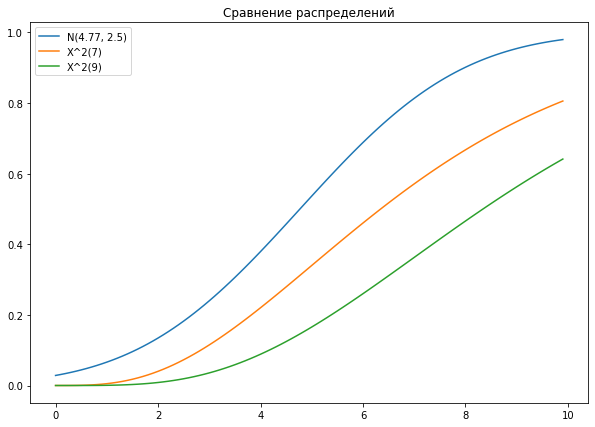

In [206]:
ax = np.arange(0,10,0.1)
plt.figure(figsize=(10,7))
plt.plot(ax, norm(teta1_est, teta2_est).cdf(ax), label="N(4.77, 2.5)")
plt.plot(ax, chi2.cdf(ax, df = 7), label = 'X^2(7)')
plt.plot(ax, chi2.cdf(ax, df = 9), label = 'X^2(9)')
plt.title("Сравнение распределений")
plt.legend()
plt.show()